# AI for Earth System Science Hackathon 2020

# GECKO-A Emulation

David John Gagne, Siyuan Wang, Charlie Becker, Keely Lawrence, Alma Hodzic, Natasha Flyer

## Introduction

![GECKO](gecko_image.png)

Natural and anthropogenic sources emit a large number of volatile organic compounds (VOCs). These compounds greatly affect the “self-cleaning capacity” of the atmosphere. These compounds can also undergo complicated chemical and physical processes in the atmosphere, forming organic aerosols. Organic aerosols have significant direct (absorbing/scattering) and indirect (affect cloud formation/properties) radiation effect.

In order to understand the broad impacts of VOCs on air quality and climate, we need to understand their sources and fates in the atmosphere. Many of these compounds can be directly emitted, or be produced from other compounds; in the meantime, they can undergo a variety of chemical reactions in the atmosphere. The chemical mechanism of these VOCs in the atmosphere can be very highly complicated, especially involving the formation of organic aerosols.

Most air quality models or chemistry-climate models are equipped with chemical mechanisms consisting of hundreds-thousands of chemical reactions. It is often found that such simplified chemical mechanisms are incapable to describe the complexity in the atmosphere. A widely used “near-explicit” chemical mechanism (Master Chemical Mechanism) consists of tens of thousands of chemical reactions, which still cannot capture the behavior and characteristics of the formation of organic aerosols. Such “near-explicit” mechanism is too computationally demanding for most air quality models or chemistry-climate models already.

NCAR (USA) and Centre National de la Recherche Scientifique (CNRS, France) jointly developed a hyper-explicit chemical mechanism: Generator of Explicit Chemistry and Kinetics of Organics in the Atmosphere (GECKO-A). GECKO-A can generate chemical mechanisms based on how the molecules/bonds/atoms interact with each other. Chemical mechanisms generated by GECKO-A usually include millions to tens of millions of reactions. Due to the remarkable computational cost, no air quality models or chemistry-climate models can afford to run with GECKO-A in the foreseeable future. There is a growing interest in the community to implement such complicated mechanisms into air quality models or chemistry-climate models, to study the broader impacts on air quality, human health, and the climate system.

Machine‐learning and artificial intelligence have proven to be a valuable tool in atmospheric science. Recent years have seen quite a few inspiring applications in developing machine-learning emulators using explicit/process-level models and implementing the trained emulators into large-scale models. Such explicit/process-level models are otherwise too expensive for large-scale models.

The goal of this project is to train the machine-learning emulator using the “library” generated by the hyper-explicit chemical mechanism, GECKO-A.

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm

In [ ]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn

     |████████████████████████████████| 4.1MB 2.7MB/s 
     |████████████████████████████████| 327kB 30.7MB/s 


In [ ]:
pip install --upgrade pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.5)


In [ ]:
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
%matplotlib inline

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

**Data generation procedure**: The machine-learning training dataset in this project (or library) is generated by the hyper-explicit chemical mechanism, GECKO-A. This library consists of results from thousands of GECKO-A simulations under vastly different conditions. More information about GECKO-A can be found [here](https://www2.acom.ucar.edu/modeling/gecko). Each model run lasts 5 simulation days.
 
### Potential Input Variables
 
* Temperature (K): The temperature at which the GECKO-A experiments were conducted. Temperature will affect the reaction rates of many reactions. It also affects the partitioning of a given compound between the gas-phase and particle-phase.
* Solar zenith angle (degree): The solar zenith angle at which the GECKO-A experiments were conducted. This will affect the photolysis reactions. 
* Pre-existing aerosols (micrograms per cubic meter): Depending on the environmental conditions (e.g., temperature) and the vapor pressure, a compound can deposit onto (pre-existing) aerosols or evaporate from the aerosols. 
* NOx (ppb): concentration of nitrogen oxides. These are important compounds in the atmosphere, affecting the chemical mechanisms of many volatile organic compounds.
* O3 (ppb): concentration of ozone. It’s another important compounds in the atmosphere, affecting the chemical mechanisms of many VOCs.
* OH (10^6 molecules per cubic centimeter): concentration of hydroxyl radicals (OH). It’s one of the most important oxidants in the atmosphere, largely driving the oxidation of many VOCs.

### Output Variables

* Precursor (micrograms per cubic meter): time series of the VOC precursor. We call it “precursor” because it’ll undergo chemical reactions and produce other compounds.
* Gas (micrograms per cubic meter): mass concentration of products in the gas-phase.
* Aerosol (micrograms per cubic meter): mass concentration of products in the aerosol-phase.

### Metadata

| Metadata | Units | Label | 
| ------------- | :----:|:----------- | 
| Number Experiments   | 2000     | id | 
| Total Timesteps   | 1440     | Time |
| Timestep Delta   | 300 seconds | - |


### Potential Input Variables

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Precursor  | ug/m3     | Varies | 
| Gas   | ug/m3     | Varies   |
| Aerosol   | ug/m3     | Varies |
| Temperature   | K     | Static         |
| Solar Zenith Angle   | degree     | Static        |
| Pre-existing Aersols   | ug/m3     | Static         |
| o3  | ppb     | Static         |
| nox   | ppb     | Static         |
| oh   | 10^6 molec/cm3     | Static         |

### Potential Output Variables

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Precursor (at t+1) | ug/m3     | Varies | 
| Gas   (at t+1)  | ug/m3   | Varies   |
| Aerosol (at t+1)  | ug/m3     | Varies |

### Training, validation, and testing sets

This training dataset/library consists of 2000 GECKO experiments, containing the results for 5-day runs (1440 timepoints/samples at 300 second intervals). The data has already been split randomly into training/validation/test sets of 1400/200/200 experiments (and 200 experiments for a hidden test set). Thus, the training set consists of 2,016,000 samples, and the test/validation sets consist of 288,000 samples.

In [ ]:
# -----------------------------------------------
""" Data Processing """

def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data
# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return
# -----------------------------------------------
""" Models """
def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod

def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble(input_data, mod, num_experiments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_experiments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_experiments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_experiments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

In [ ]:
# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

In [ ]:
test.head()

Time [s]  Precursor [ug/m3]  ...  oh (10^6 molec/cm3)       id
28800     1.000000           0.069675  ...             6.090439  Exp1155
28801   301.207794           0.068014  ...             6.090439  Exp1155
28802   601.415588           0.066392  ...             6.090439  Exp1155
28803   901.623352           0.064809  ...             6.090439  Exp1155
28804  1201.831177           0.063264  ...             6.090439  Exp1155

[5 rows x 11 columns]

In [ ]:
train.head()

Time [s]  Precursor [ug/m3]  ...  oh (10^6 molec/cm3)       id
0     1.000000           0.069675  ...             7.360145  Exp1666
1   301.207794           0.067673  ...             7.360145  Exp1666
2   601.415588           0.065728  ...             7.360145  Exp1666
3   901.623352           0.063838  ...             7.360145  Exp1666
4  1201.831177           0.062003  ...             7.360145  Exp1666

[5 rows x 11 columns]

In [ ]:
val.head()

Time [s]  Precursor [ug/m3]  ...  oh (10^6 molec/cm3)       id
61920     1.000000           0.069675  ...             2.023871  Exp1747
61921   301.207794           0.069119  ...             2.023871  Exp1747
61922   601.415588           0.068567  ...             2.023871  Exp1747
61923   901.623352           0.068019  ...             2.023871  Exp1747
61924  1201.831177           0.067476  ...             2.023871  Exp1747

[5 rows x 11 columns]

In [ ]:
# get some summary statistics of the training data
train.groupby('id').mean().describe()

Time [s]  Precursor [ug/m3]  ...    nox (ppb)  oh (10^6 molec/cm3)
count  1.400000e+03        1400.000000  ...  1400.000000          1400.000000
mean   2.160005e+05           0.003125  ...     2.124920             5.493831
std    2.329138e-10           0.002215  ...     2.468413             2.582480
min    2.160005e+05           0.001244  ...     0.100186             1.011878
25%    2.160005e+05           0.001598  ...     0.314910             3.231017
50%    2.160005e+05           0.002253  ...     1.004467             5.479992
75%    2.160005e+05           0.003803  ...     3.059370             7.758317
max    2.160005e+05           0.012054  ...     9.980638             9.999925

[8 rows x 10 columns]

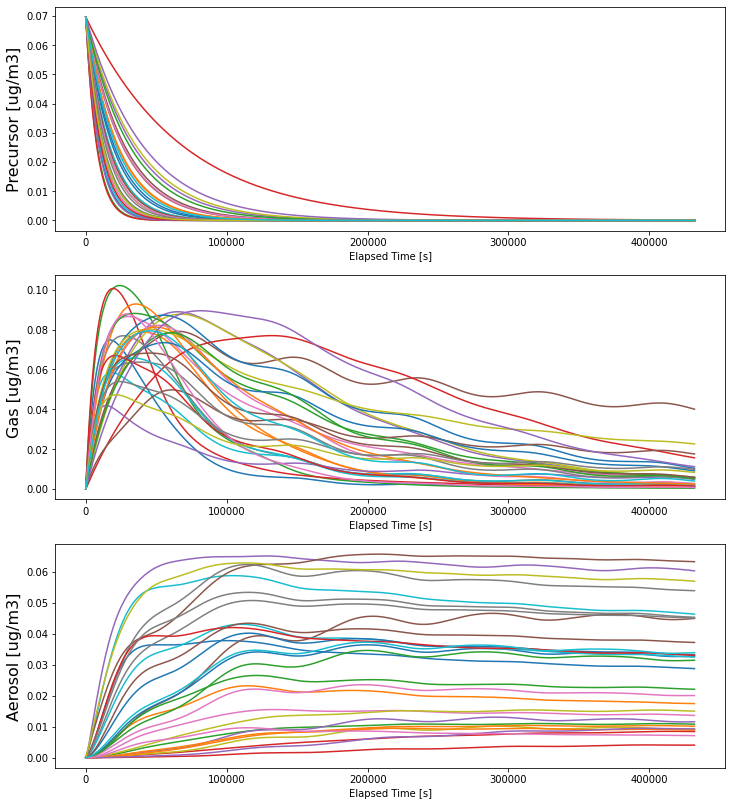

In [ ]:
# Spaghetti plot random experiment timeseries (randomly choose 30 out of 1400 experiments)
num_experiments = 30
exps = sorted(random.sample(list(train['id'].unique()), num_experiments))
plot_df = train.loc[train['id'].isin(exps)].reset_index(drop=True)

fig, ax = plt.subplots(3,1, figsize=(12,14))
for i,lab in enumerate(['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug/m3]']):
    for exp in exps:
        ax[i].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,i+1])
    ax[i].set_xlabel('Elapsed Time [s]')
    ax[i].set_ylabel(lab, fontsize=16) 

## Data Preperation
Here we prepare the data for machine learning by taking the respective variables from each column, offsetting the output data by 1 timestep (this is done inside the `prepare_data()` function, and scale. Make sure to not re-fit the scaler on the validation/test data and only `transform()` it. 

In [ ]:
input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])

In [ ]:
scaled_train_in.shape, scaled_train_out.shape, scaled_val_in.shape, scaled_val_out.shape,

((2015999, 9), (2015999, 3), (287999, 9), (287999, 3))

## Baseline Machine Learning Model
Here we use a pretty basic Dense Neural Network to predict the 3 output variables at the next timestep. We will then feed this into the Box Emulator model to run forward in time for n timesteps.

In [ ]:
%%time
tf.random.set_seed(seed)
mod = dense_neural_net()
history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)
mod.summary()

Epoch 1/5
7875/7875 [==============================] - 18s 2ms/step - loss: 5.6077e-04 - val_loss: 3.2226e-04
Epoch 2/5
7875/7875 [==============================] - 19s 2ms/step - loss: 2.8969e-04 - val_loss: 2.8833e-04
Epoch 3/5
7875/7875 [==============================] - 19s 2ms/step - loss: 2.8605e-04 - val_loss: 2.8116e-04
Epoch 4/5
7875/7875 [==============================] - 19s 2ms/step - loss: 2.8473e-04 - val_loss: 2.9329e-04
Epoch 5/5
7875/7875 [==============================] - 19s 2ms/step - loss: 2.8389e-04 - val_loss: 2.7630e-04
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1000      
_________________________________________________________________
dense_4 (Dense)              (None, 1

## Box Emulator Model
This model (`box_emulator()`), takes one timestep of initial conditions to feed the neural network we built. It then predicts one timestep, and uses the prediction as the input for another prediction (along with the static environmental variables), and so forth for *n* timesteps. In actual practice, the environmental variables from the climate model would be varying as well, but we use a variety of experiments with variable enviromental factors to learn from and simplify the process. 

The `run_emulator_ensemble()` function takes *n* random experiments and runs the `box_emulator()` for the length of each experiment and returns the predictions as well as the corresponding truth values.\

We can then use the `evaluate_box_mod()` to return a variety of performance metrics.

NOTE: It takes ~40 seconds per experiment to run the box emulator.

In [ ]:
%%time
random.seed(seed)
num_exps = 5
pred_box, true_box = run_emulator_ensemble(val_in, mod, num_exps, input_vars, input_scaler, output_scaler)

CPU times: user 3min 19s, sys: 4.65 s, total: 3min 24s
Wall time: 3min 21s


## Evaluation

In [ ]:
# get predictions and truth
pred_nn = pd.DataFrame(output_scaler.inverse_transform(mod.predict(scaled_val_in))).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

Metrics for base model:
RMSE: Precursor: 0.00023, Gas: 0.00019, Aerosols: 0.00022
R2: Precursor: 0.99972, Gas: 0.99994, Aerosols: 0.99993
Hellenger Distance: Precursor: 0.00003, Gas: 0.00002, Aerosols: 0.00568


Metrics for Box Emulator:
RMSE: Precursor: 0.00652, Gas: 0.08051, Aerosols: 0.05283
R2: Precursor: 0.94809, Gas: 0.04382, Aerosols: 0.53212
Hellenger Distance: Precursor: 0.55399, Gas: 0.66029, Aerosols: 0.98853


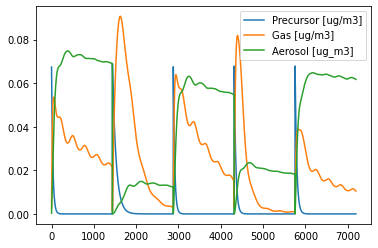

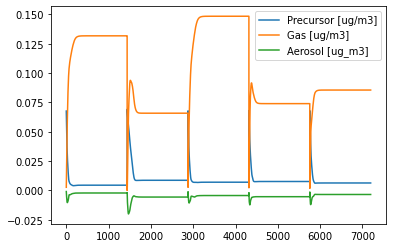

In [ ]:
print('Metrics for Box Emulator:')
evaluate_mod(true_box, pred_box)

## Quick plot to see if emulator is capturing the patterns
true_box.iloc[:,0:3].plot()
pred_box.iloc[:,0:3].plot()

As you can see, it is relatively easy to train the base network to predict t+1 values. It is far more challenging to model the length of the experiment (~1440 timesteps). Furthermore, you may discover that better performance on the neural network may not mean better performance with the box emulator. 

Some potential ideas for better emulator performance: adding some noise to the training data to prevent overfitting, or using a recurrent neural network/LSTM to utilize more than one timestep to inform prediction of the next. 

| Model Type | Metric | Variable |||
| ------------- | :----:|:-------:|:------:|:-----|
|  Baseline DNN|| Precursor | Gas | Aerosols |   
|              | RMSE: |**0.00019**|**0.00035**|**0.00014**|
|              | R2: |**0.99979**|**0.99984**|**0.99997**|
|              | Hellenger Distance: |**0.00002**|**0.00011**|**0.00004**|
|||||
|  Box Emulator|| Precursor | Gas | Aerosol |   
|              | RMSE: |**0.007**|**0.048**|**0.021**|
|              | R2: |**0.685**|**0.031**|**0.410**|
|              | Hellenger Distance: |**0.067**|**0.256**|**0.329**|

## Hackathon Challenges

### Monday

* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

#### Load the data

In [ ]:
# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])

In [ ]:
train.head()

Time [s]  Precursor [ug/m3]  ...  oh (10^6 molec/cm3)    id
indx                                  ...                           
0        1.000000           0.069675  ...             7.360145  1666
1      301.207794           0.067673  ...             7.360145  1666
2      601.415588           0.065728  ...             7.360145  1666
3      901.623352           0.063838  ...             7.360145  1666
4     1201.831177           0.062003  ...             7.360145  1666

[5 rows x 11 columns]

In [ ]:
# view dimensions of data
train.shape, test.shape, val.shape

((2016000, 11), (288000, 11), (288000, 11))

#### Create an exploratory visualization of the data

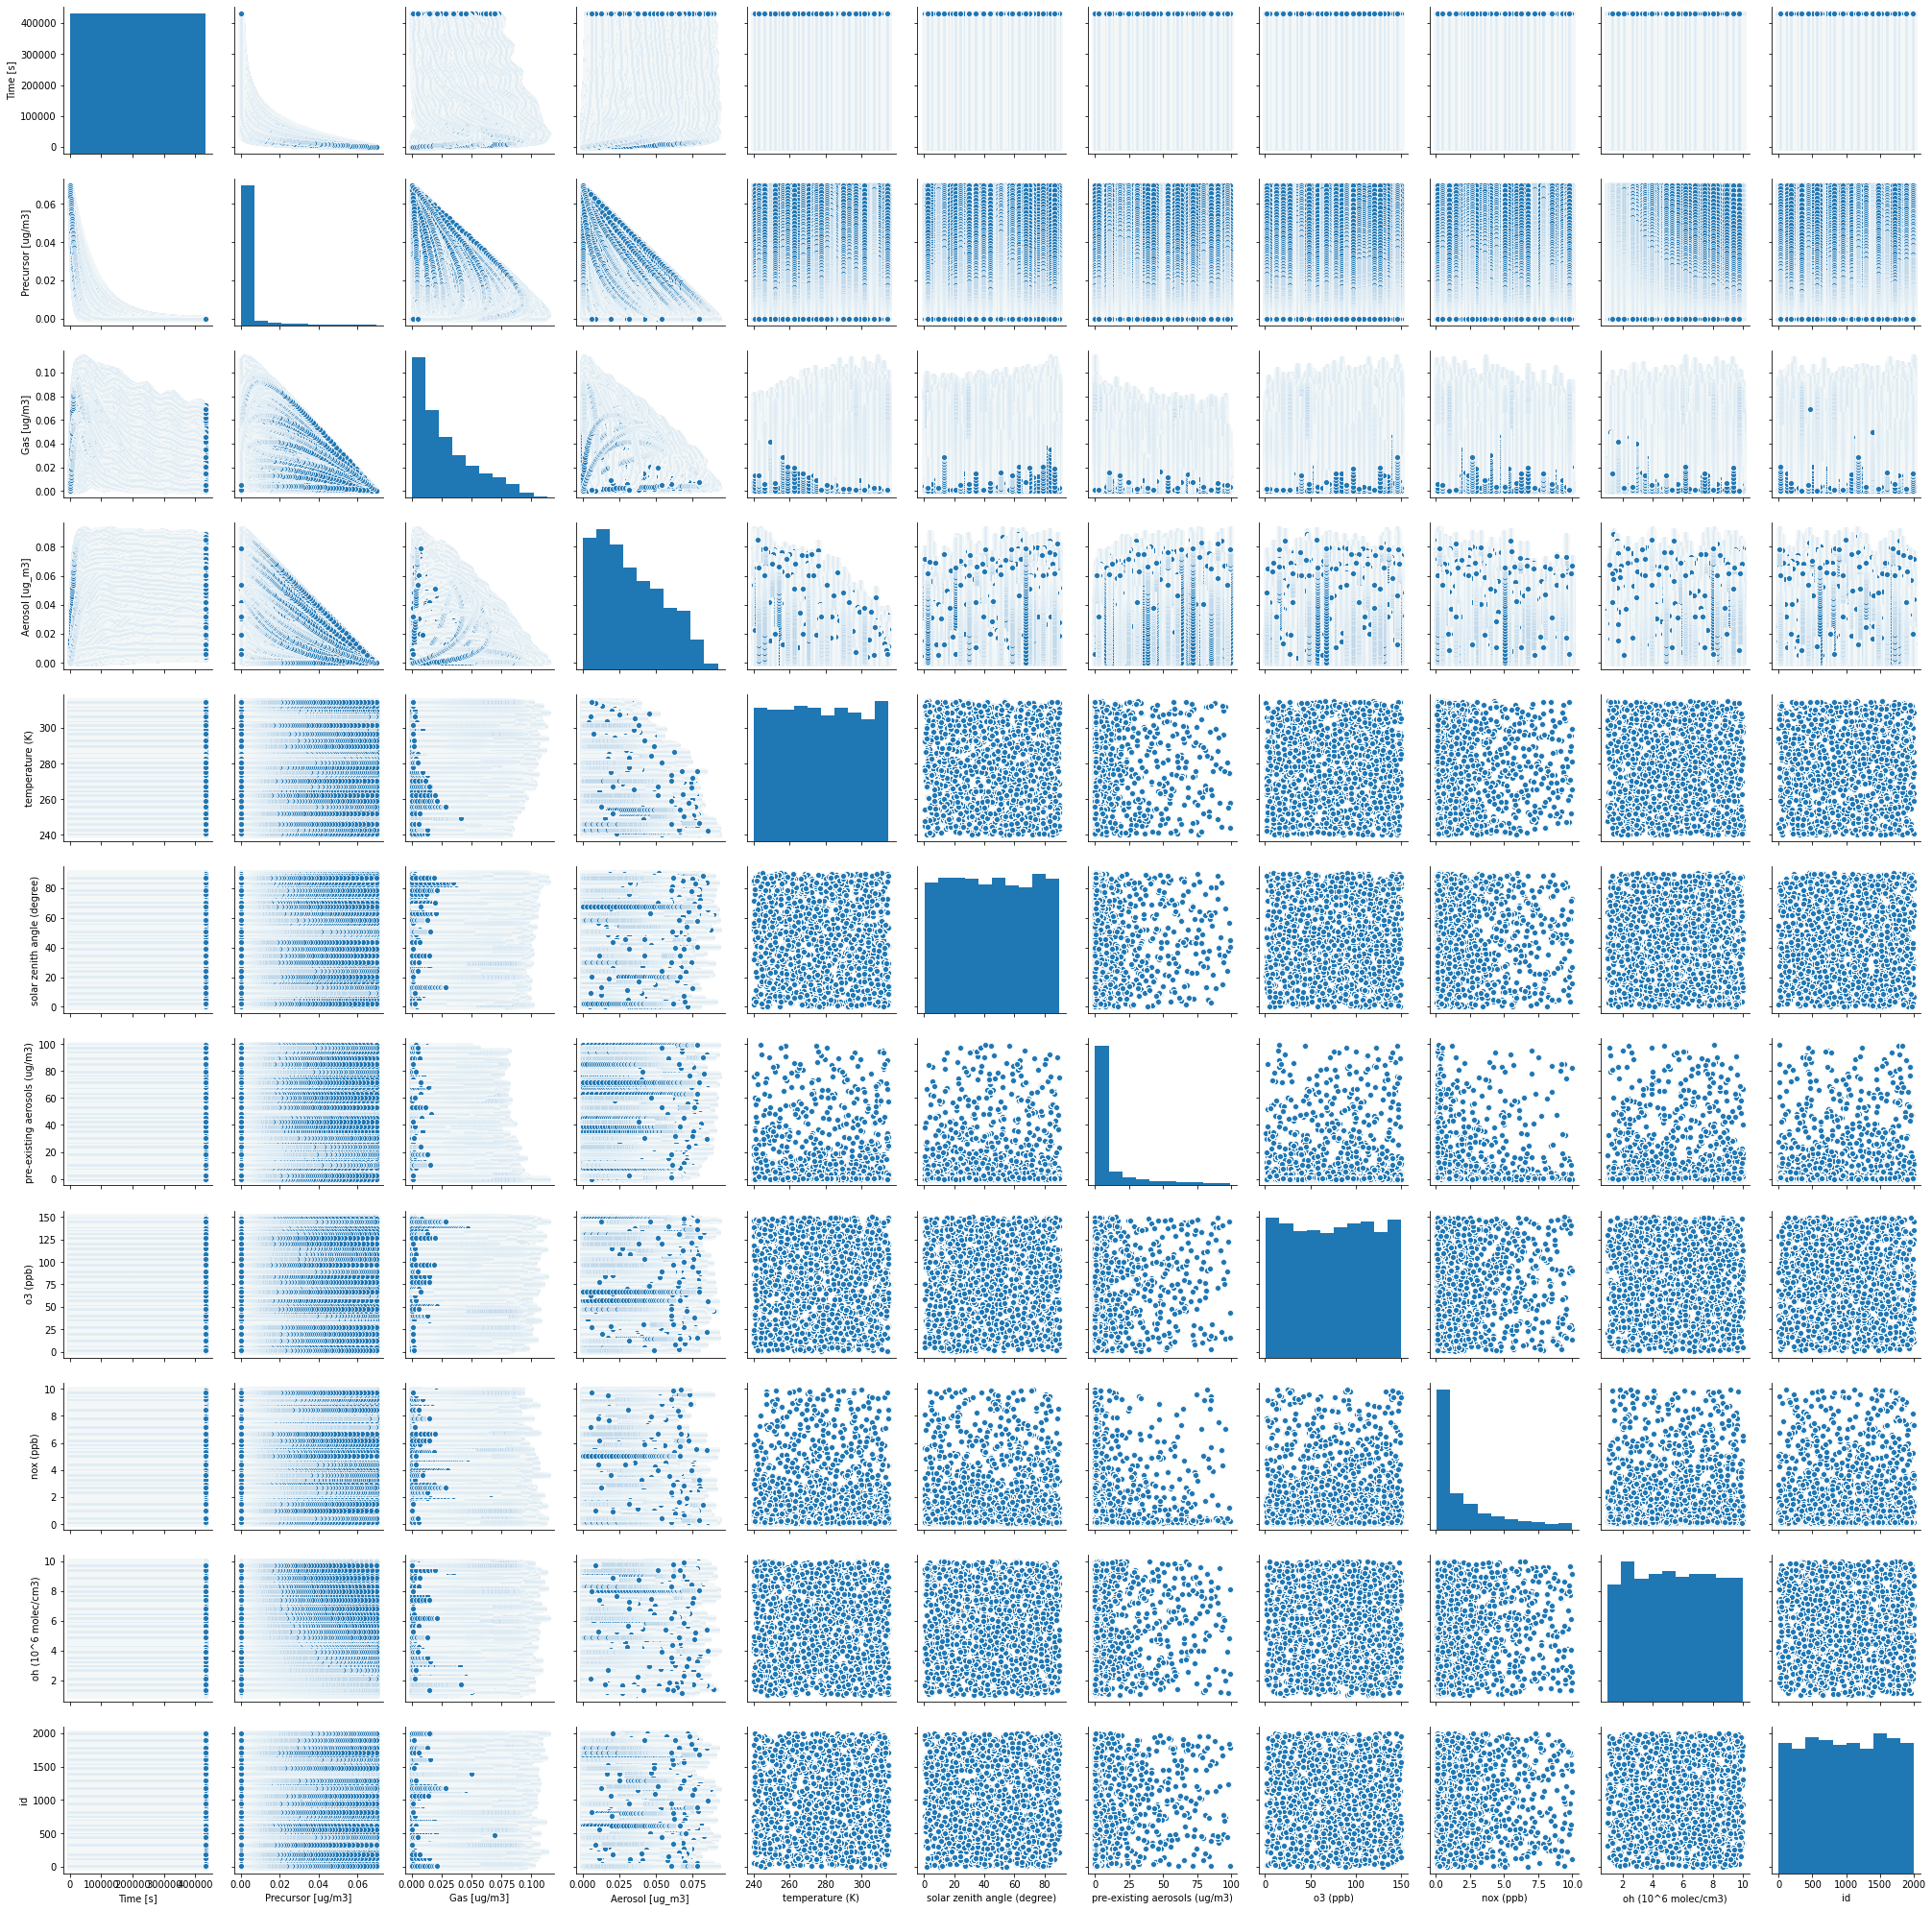

In [ ]:
import seaborn as sns
sns.pairplot(train)

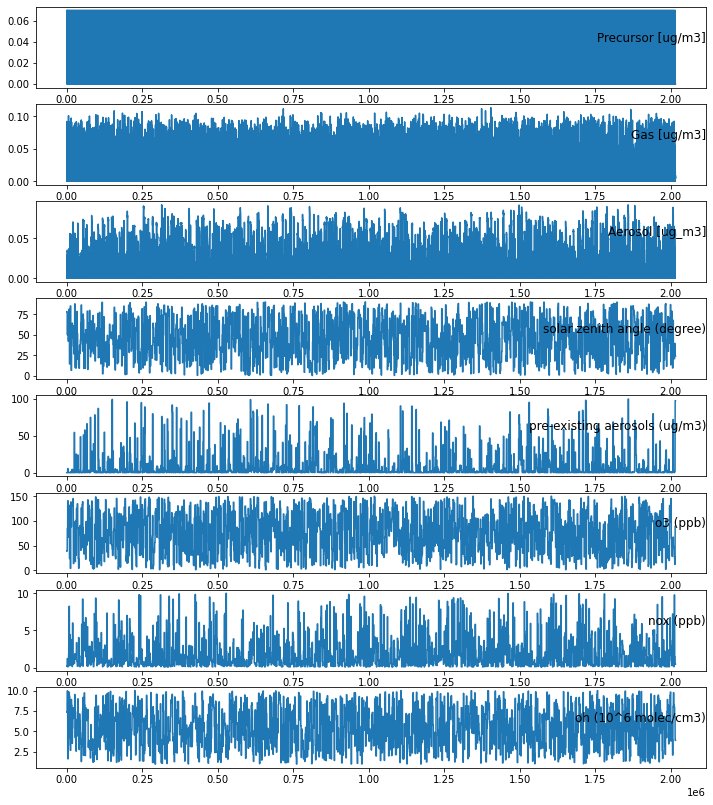

In [ ]:
from matplotlib import pyplot
# specify columns to plot
values=train.values
groups = [1, 2, 3, 5, 6, 7, 8, 9]
i = 1
# plot each column
pyplot.figure(figsize=(12,14))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(train.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [ ]:
train.head()

Time [s]  Precursor [ug/m3]  ...  oh (10^6 molec/cm3)    id
indx                                  ...                           
0        1.000000           0.069675  ...             7.360145  1666
1      301.207794           0.067673  ...             7.360145  1666
2      601.415588           0.065728  ...             7.360145  1666
3      901.623352           0.063838  ...             7.360145  1666
4     1201.831177           0.062003  ...             7.360145  1666

[5 rows x 11 columns]

#### Test two different transformation and scaling methods

In [ ]:
# Transform right-skewed data
train['Transformed Pre-existing Aerosols [ug/m3]']=np.cbrt(train['pre-existing aerosols (ug/m3)'])

train['Log nox[ppb]']=np.log10(train['nox (ppb)'])                            

train.head()

Time [s]  ...  Log nox[ppb]
0     1.000000  ...     -0.686071
1   301.207794  ...     -0.686071
2   601.415588  ...     -0.686071
3   901.623352  ...     -0.686071
4  1201.831177  ...     -0.686071

[5 rows x 13 columns]

Text(0.5, 0, 'log10 nox (ppb)')

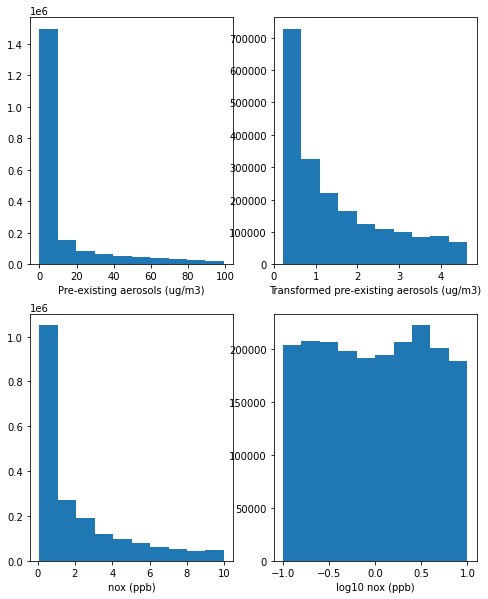

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(8,10))
ax[0][0].hist(train['pre-existing aerosols (ug/m3)'])
ax[0][0].set_xlabel('Pre-existing aerosols (ug/m3)')
ax[0][1].hist(train['Transformed Pre-existing Aerosols [ug/m3]'])
ax[0][1].set_xlabel('Transformed pre-existing aerosols (ug/m3)')

ax[1][0].hist(train['nox (ppb)'])
ax[1][0].set_xlabel('nox (ppb)')
ax[1][1].hist(train['Log nox[ppb]'])
ax[1][1].set_xlabel('log10 nox (ppb)')

In [ ]:
train = train.drop(columns = ['pre-existing aerosols (ug/m3)','nox (ppb)'])
train.head()

Time [s]  ...  Log nox[ppb]
0     1.000000  ...     -0.686071
1   301.207794  ...     -0.686071
2   601.415588  ...     -0.686071
3   901.623352  ...     -0.686071
4  1201.831177  ...     -0.686071

[5 rows x 11 columns]

#### Test one dimensionality reduction method

It was unclear to use how dimensionality reduction would be relevant to the GECKO dataset. We are used to using PCA, for example, when we have many output variables. Here we have only 3. David John seems to concur: "In the hackathon gecko dataset it is not really relevant unless you wanted to encode trends in time. ... PCA may be interesting to apply to the dataset from an analysis perspective to analyze how the data correlated with each other but is not necessary for this particular problem."

However, it might be useful to run PCA on the input variables, as several of them (o3, oh, solar zenith angle, and temperature) appear to be co-linear.

#### Train a linear model

In [ ]:
# linear regression model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
regressor = LinearRegression()  
historyregressor=regressor.fit(scaled_train_in, scaled_train_out) #training the algorithm
regressor.score(scaled_train_in, scaled_train_out)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9932081331228784

In [ ]:
regressor.score(scaled_val_in, scaled_val_out)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9933532386220382

#### Train a decision tree ensemble method of your choice

In [ ]:
# single decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dt = DecisionTreeRegressor(max_depth=2, random_state=0)
historydt=dt.fit(scaled_train_in[::10], scaled_train_out[::10])
dt.score(scaled_val_in, scaled_val_out)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.6661749871336866

In [ ]:
dt.score(scaled_val_in, scaled_val_out)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.6661749871336866

In [ ]:
# random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
historyclf=clf.fit(scaled_train_in[::10], scaled_train_out[::10])
clf.score(scaled_train_in[::10], scaled_train_out[::10])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.649257207141381

In [ ]:
clf.score(scaled_val_in, scaled_val_out)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.6688741492156988

In [ ]:
# importing the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline

### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

#### Train a densely connected neural network

In [ ]:
# with loss='mean_squared_error'
import keras
from keras.models import Sequential
from keras.layers import Dense
tf.random.set_seed(seed)
model1=Sequential()
# Creating the input layer and first hidden layer
model1.add(Dense(input_dim = 9, units = 10, activation='relu', kernel_initializer='uniform'))
# Create second hidden layer
model1.add(Dense(units = 20, activation='relu', kernel_initializer='uniform'))
# Create output layer (units=number of output variable)
model1.add(Dense(units = 3, activation='sigmoid', kernel_initializer='uniform'))
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
historyd=model1.fit(scaled_train_in,scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)

Train on 2015999 samples, validate on 287999 samples
Epoch 1/5
2015999/2015999 [==============================] - 12s 6us/step - loss: 0.0043 - accuracy: 0.9545 - val_loss: 5.2234e-04 - val_accuracy: 0.9827
Epoch 2/5
2015999/2015999 [==============================] - 12s 6us/step - loss: 4.9860e-04 - accuracy: 0.9823 - val_loss: 4.8596e-04 - val_accuracy: 0.9846
Epoch 3/5
2015999/2015999 [==============================] - 12s 6us/step - loss: 4.5491e-04 - accuracy: 0.9837 - val_loss: 4.4309e-04 - val_accuracy: 0.9834
Epoch 4/5
2015999/2015999 [==============================] - 12s 6us/step - loss: 3.7759e-04 - accuracy: 0.9888 - val_loss: 3.4804e-04 - val_accuracy: 0.9924
Epoch 5/5
2015999/2015999 [==============================] - 12s 6us/step - loss: 3.4664e-04 - accuracy: 0.9928 - val_loss: 3.4226e-04 - val_accuracy: 0.9933


In [ ]:
%%time
random.seed(seed)
num_exps = 5
pred_box1, true_box1 = run_emulator_ensemble(val_in, model1, num_exps, input_vars, input_scaler, output_scaler)

CPU times: user 4.21 s, sys: 309 ms, total: 4.52 s
Wall time: 3.85 s


In [ ]:
pred_nn1 = pd.DataFrame(output_scaler.inverse_transform(model1.predict(scaled_val_in))).iloc[1:,:]
true_val1 = val_out.iloc[:-1,1:4]



#### Train a recurring neural network

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


In [ ]:
trainx=scaled_train_in.reshape(scaled_train_in.shape[0],1,scaled_train_in.shape[1])
testx=scaled_val_in.reshape(scaled_val_in.shape[0],1,scaled_val_in.shape[1])
print(trainx.shape, testx.shape)

(2015999, 1, 9) (287999, 1, 9)


In [ ]:
# design network
model = Sequential()
model.add(LSTM(50,input_shape=(trainx.shape[1], trainx.shape[2])))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
# fit network
history1 = model.fit(trainx, scaled_train_out, epochs=10, batch_size=256, validation_data=(testx, scaled_val_out), verbose=2, shuffle=False)


Train on 2015999 samples, validate on 287999 samples
Epoch 1/10
 - 25s - loss: 0.0019 - accuracy: 0.9710 - val_loss: 3.0824e-04 - val_accuracy: 0.9953
Epoch 2/10
 - 24s - loss: 4.2355e-04 - accuracy: 0.9876 - val_loss: 3.3451e-04 - val_accuracy: 0.9949
Epoch 3/10
 - 24s - loss: 3.9179e-04 - accuracy: 0.9886 - val_loss: 2.9795e-04 - val_accuracy: 0.9953
Epoch 4/10
 - 24s - loss: 3.7355e-04 - accuracy: 0.9893 - val_loss: 3.0600e-04 - val_accuracy: 0.9953
Epoch 5/10
 - 24s - loss: 3.6135e-04 - accuracy: 0.9900 - val_loss: 3.1308e-04 - val_accuracy: 0.9953
Epoch 6/10
 - 24s - loss: 3.5073e-04 - accuracy: 0.9904 - val_loss: 3.0533e-04 - val_accuracy: 0.9956
Epoch 7/10
 - 24s - loss: 3.4268e-04 - accuracy: 0.9916 - val_loss: 3.1282e-04 - val_accuracy: 0.9962
Epoch 8/10
 - 24s - loss: 3.3230e-04 - accuracy: 0.9916 - val_loss: 3.0561e-04 - val_accuracy: 0.9968
Epoch 9/10
 - 26s - loss: 3.2914e-04 - accuracy: 0.9919 - val_loss: 3.0725e-04 - val_accuracy: 0.9958
Epoch 10/10
 - 24s - loss: 3.2552

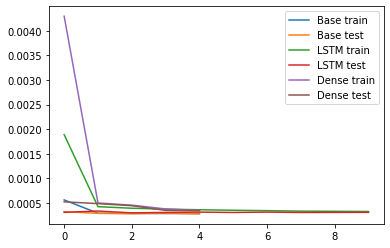

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='Base train')
pyplot.plot(history.history['val_loss'], label='Base test')

pyplot.plot(history1.history['loss'], label='LSTM train')
pyplot.plot(history1.history['val_loss'], label='LSTM test')

pyplot.plot(historyd.history['loss'], label='Dense train')
pyplot.plot(historyd.history['val_loss'], label='Dense test')

pyplot.legend()
pyplot.show()

In [ ]:
l_predictions=model.predict(testx)
l_pred_nn=pd.DataFrame(output_scaler.inverse_transform(l_predictions)).iloc[1:,:]
l_true_val = pd.DataFrame(val_out.iloc[:-1,1:4])



In [ ]:
# Merge predictions into out table
out=val_out
out['Precursor.pred']=pred_nn[0].values.astype(np.float64)
out['Gas.pred']=pred_nn[1].values.astype(np.float64)
out['Aerosol.pred']=pred_nn[2].values.astype(np.float64)
out

Time [s]  Precursor [ug/m3]  ...  Gas.pred  Aerosol.pred
indx                                       ...                        
1277281     301.207794           0.067376  ...  0.003146      0.001997
1277282     601.415588           0.065155  ...  0.005646      0.002298
1277283     901.623352           0.063007  ...  0.008413      0.002783
1277284    1201.831177           0.060930  ...  0.011108      0.003312
1277285    1502.038940           0.058921  ...  0.013718      0.003877
...                ...                ...  ...       ...           ...
2178715  430799.156250           0.000014  ...  0.020647      0.045715
2178716  431099.375000           0.000014  ...  0.020590      0.045726
2178717  431399.593750           0.000014  ...  0.020533      0.045737
2178718  431699.781250           0.000014  ...  0.020476      0.045749
2178719  432000.000000           0.000014  ...  0.020420      0.045759

[287999 rows x 8 columns]

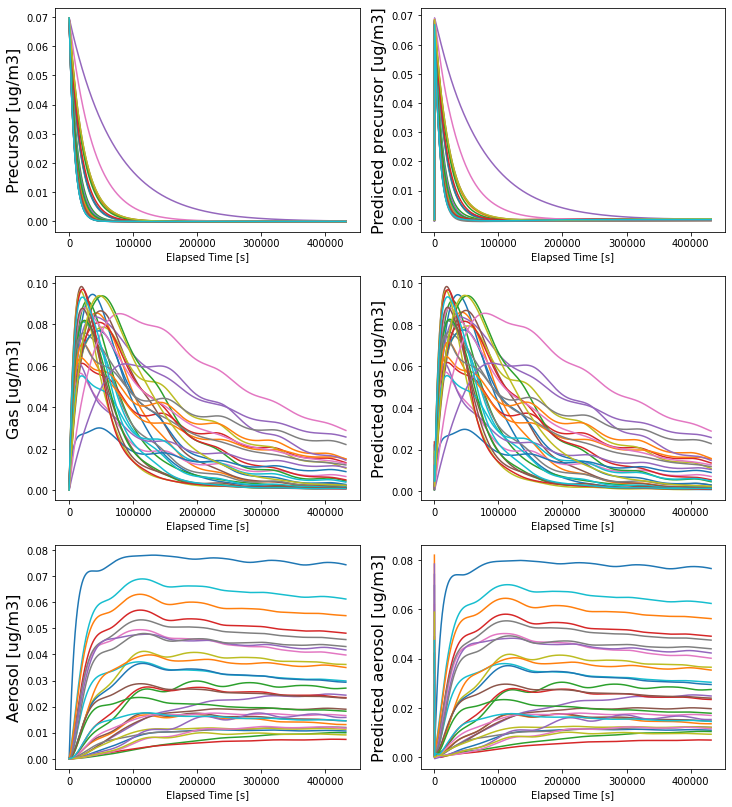

In [ ]:
# Spaghetti plot random experiment timeseries (randomly choose 30 out of 1400 experiments)
num_experiments = 30
exps = sorted(random.sample(list(out['id'].unique()), num_experiments))
plot_df = out.loc[out['id'].isin(exps)].reset_index(drop=True)

fig, ax = plt.subplots(3,2, figsize=(12,14))

for exp in exps:
  ax[0][0].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,1])
  ax[0][0].set_xlabel('Elapsed Time [s]')
  ax[0][0].set_ylabel('Precursor [ug/m3]',fontsize=16)

  ax[0][1].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,5])
  ax[0][1].set_xlabel('Elapsed Time [s]')
  ax[0][1].set_ylabel('Predicted precursor [ug/m3]',fontsize=16)

  ax[1][0].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,2])
  ax[1][0].set_xlabel('Elapsed Time [s]')
  ax[1][0].set_ylabel('Gas [ug/m3]',fontsize=16)

  ax[1][1].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,6])
  ax[1][1].set_xlabel('Elapsed Time [s]')
  ax[1][1].set_ylabel('Predicted gas [ug/m3]',fontsize=16)

  ax[2][0].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,3])
  ax[2][0].set_xlabel('Elapsed Time [s]')
  ax[2][0].set_ylabel('Aerosol [ug/m3]',fontsize=16)

  ax[2][1].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,7])
  ax[2][1].set_xlabel('Elapsed Time [s]')
  ax[2][1].set_ylabel('Predicted aerosol [ug/m3]',fontsize=16)

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

#### Calculate three relevant evaluation metrics for each ML solution and baseline

In [ ]:
val_out.iloc[:-1,1:4]

Precursor [ug/m3]  Gas [ug/m3]  Aerosol [ug_m3]
indx                                                    
1277281           0.067376     0.002850         0.000351
1277282           0.065155     0.005897         0.000889
1277283           0.063007     0.008795         0.001457
1277284           0.060930     0.011550         0.002052
1277285           0.058921     0.014166         0.002672
...                    ...          ...              ...
2178714           0.000014     0.020481         0.045010
2178715           0.000014     0.020424         0.045021
2178716           0.000014     0.020368         0.045033
2178717           0.000014     0.020311         0.045044
2178718           0.000014     0.020256         0.045055

[287998 rows x 3 columns]

In [ ]:
#### Calculate three relevant evaluation metrics for each ML solution and baseline

In [ ]:
print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)
print("\n")
print('Metrics for densely connected neural network:')
evaluate_mod(true_val1, pred_nn1)
print("\n")
print('Metrics for LSTM:')
evaluate_mod(l_true_val, l_pred_nn)

Metrics for base model:
RMSE: Precursor: 0.00023, Gas: 0.00019, Aerosols: 0.00022
R2: Precursor: 0.99972, Gas: 0.99994, Aerosols: 0.99993
Hellenger Distance: Precursor: 0.00003, Gas: 0.00002, Aerosols: 0.00568


Metrics for densely connected neural network:
RMSE: Precursor: 0.00038, Gas: 0.00078, Aerosols: 0.00111
R2: Precursor: 0.99912, Gas: 0.99906, Aerosols: 0.99766
Hellenger Distance: Precursor: 0.00325, Gas: 0.00608, Aerosols: 0.02165


Metrics for LSTM:
RMSE: Precursor: 0.00035, Gas: 0.00051, Aerosols: 0.00079
R2: Precursor: 0.99949, Gas: 0.99972, Aerosols: 0.99961
Hellenger Distance: Precursor: 0.00024, Gas: 0.00013, Aerosols: 0.00236


In [ ]:
# Merge predictions into out table
merge=val_out.iloc[:-1,0:5]
merge['Precursor.Base']=pred_nn[0].values.astype(np.float64)
merge['Gas.Base']=pred_nn[1].values.astype(np.float64)
merge['Aerosol.Base']=pred_nn[2].values.astype(np.float64)

merge['Precursor.Dense']=pred_nn1[0].values.astype(np.float64)
merge['Gas.Dense']=pred_nn1[1].values.astype(np.float64)
merge['Aerosol.Dense']=pred_nn1[2].values.astype(np.float64)

merge['Precursor.LSTM']=l_pred_nn[0].values.astype(np.float64)
merge['Gas.LSTM']=l_pred_nn[1].values.astype(np.float64)
merge['Aerosol.LSTM']=l_pred_nn[2].values.astype(np.float64)

merge.reset_index(drop=True,inplace=True)
merge


Time [s]  Precursor [ug/m3]  ...  Gas.LSTM  Aerosol.LSTM
0          301.207794           0.067376  ...  0.005643      0.002299
1          601.415588           0.065155  ...  0.008410      0.002785
2          901.623352           0.063007  ...  0.011105      0.003315
3         1201.831177           0.060930  ...  0.013715      0.003881
4         1502.038940           0.058921  ...  0.016228      0.004477
...               ...                ...  ...       ...           ...
287993  430498.968750           0.000014  ...  0.020648      0.045723
287994  430799.156250           0.000014  ...  0.020591      0.045734
287995  431099.375000           0.000014  ...  0.020534      0.045745
287996  431399.593750           0.000014  ...  0.020477      0.045757
287997  431699.781250           0.000014  ...  0.020421      0.045767

[287998 rows x 14 columns]

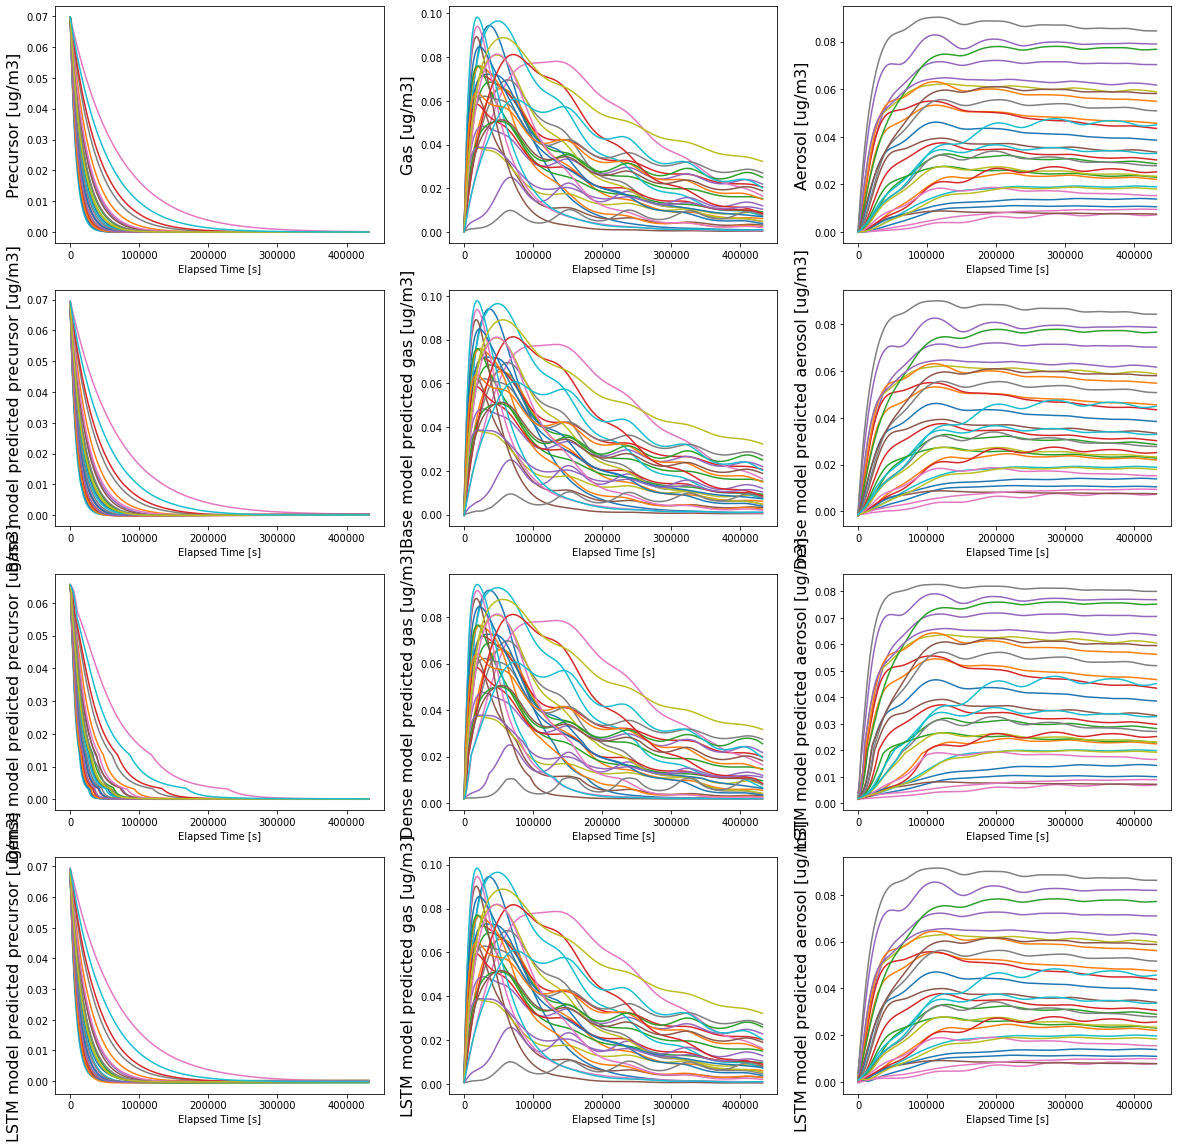

In [ ]:
# Spaghetti plot random experiment timeseries (randomly choose 30 merge of 1400 experiments)
num_experiments = 30
exps = sorted(random.sample(list(merge['id'].unique()), num_experiments))
plot_df = merge.loc[merge['id'].isin(exps)].reset_index(drop=True)

fig, ax = plt.subplots(4,3, figsize=(20,20))

for exp in exps:
  ax[0][0].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,1])
  ax[0][0].set_xlabel('Elapsed Time [s]')
  ax[0][0].set_ylabel('Precursor [ug/m3]',fontsize=16)

  ax[0][1].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,2])
  ax[0][1].set_xlabel('Elapsed Time [s]')
  ax[0][1].set_ylabel('Gas [ug/m3]',fontsize=16)

  ax[0][2].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,3])
  ax[0][2].set_xlabel('Elapsed Time [s]')
  ax[0][2].set_ylabel('Aerosol [ug/m3]',fontsize=16)

  ax[1][0].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,5])
  ax[1][0].set_xlabel('Elapsed Time [s]')
  ax[1][0].set_ylabel('Base model predicted precursor [ug/m3]',fontsize=16)

  ax[1][1].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,6])
  ax[1][1].set_xlabel('Elapsed Time [s]')
  ax[1][1].set_ylabel('Base model predicted gas [ug/m3]',fontsize=16)

  ax[1][2].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,7])
  ax[1][2].set_xlabel('Elapsed Time [s]')
  ax[1][2].set_ylabel('Dense model predicted aerosol [ug/m3]',fontsize=16)

  ax[2][0].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,8])
  ax[2][0].set_xlabel('Elapsed Time [s]')
  ax[2][0].set_ylabel('Dense model predicted precursor [ug/m3]',fontsize=16)

  ax[2][1].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,9])
  ax[2][1].set_xlabel('Elapsed Time [s]')
  ax[2][1].set_ylabel('Dense model predicted gas [ug/m3]',fontsize=16)

  ax[2][2].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,10])
  ax[2][2].set_xlabel('Elapsed Time [s]')
  ax[2][2].set_ylabel('LSTM model predicted aerosol [ug/m3]',fontsize=16)

  ax[3][0].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,11])
  ax[3][0].set_xlabel('Elapsed Time [s]')
  ax[3][0].set_ylabel('LSTM model predicted precursor [ug/m3]',fontsize=16)

  ax[3][1].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,12])
  ax[3][1].set_xlabel('Elapsed Time [s]')
  ax[3][1].set_ylabel('LSTM model predicted gas [ug/m3]',fontsize=16)

  ax[3][2].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,13])
  ax[3][2].set_xlabel('Elapsed Time [s]')
  ax[3][2].set_ylabel('LSTM model predicted aerosol [ug/m3]',fontsize=16)


Time [s]  Precursor [ug/m3]  ...  Gas.LSTM  Aerosol.LSTM
0          301.207794           0.067376  ...  0.005643      0.002299
1          601.415588           0.065155  ...  0.008410      0.002785
2          901.623352           0.063007  ...  0.011105      0.003315
3         1201.831177           0.060930  ...  0.013715      0.003881
4         1502.038940           0.058921  ...  0.016228      0.004477
...               ...                ...  ...       ...           ...
287993  430498.968750           0.000014  ...  0.020648      0.045723
287994  430799.156250           0.000014  ...  0.020591      0.045734
287995  431099.375000           0.000014  ...  0.020534      0.045745
287996  431399.593750           0.000014  ...  0.020477      0.045757
287997  431699.781250           0.000014  ...  0.020421      0.045767

[287998 rows x 14 columns]

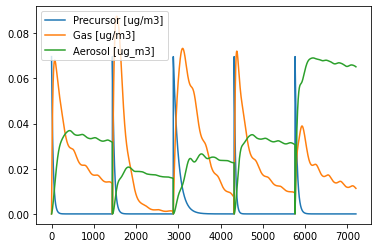

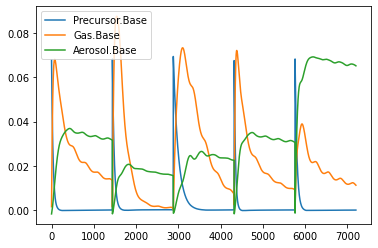

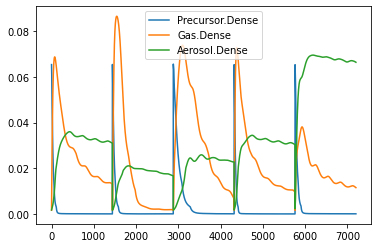

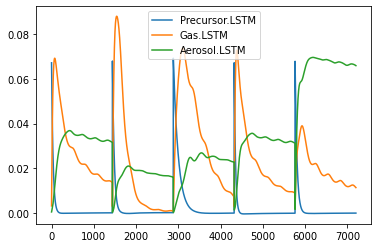

In [ ]:
# Spaghetti plot random experiment timeseries (randomly choose 30 merge of 1400 experiments)
num_experiments = 5
exps = sorted(random.sample(list(merge['id'].unique()), num_experiments))
plot_df = merge.loc[merge['id'].isin(exps)].reset_index(drop=True)


plot_df.iloc[:,1:4].plot()
plot_df.iloc[:,5:8].plot()
plot_df.iloc[:,8:11].plot()
plot_df.iloc[:,11:14].plot()

### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

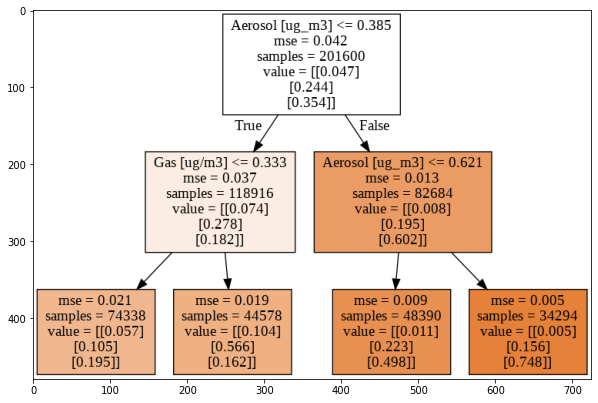

In [ ]:
# Visualising the decision tree
decision_tree_dt = tree.export_graphviz(dt, out_file='tree1.dot', feature_names=train_in.iloc[:,1:-1].columns, filled=True, max_depth=2)

# converting the dot image to png format
!dot -Tpng tree1.dot -o tree1.png

#plotting the decision trees
image1 = plt.imread('tree1.png')
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.imshow(image2)

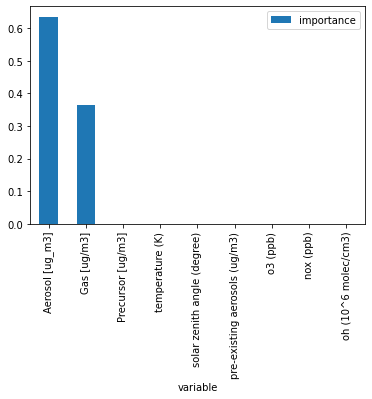

In [ ]:
# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = train_in.iloc[:,1:-1].columns
feature_importance['importance'] = clf.feature_importances_

# feature_importance values in descending order
feature=feature_importance.sort_values(by='importance', ascending=False)
feature.plot.bar(x='variable',y='importance',rot=90)


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.